# Qualifying Jeddah

In [35]:
import numpy as np
import fastf1
import fastf1.plotting
import pandas as pd
import matplotlib.pyplot as plt
from fastf1.core import Laps
from timple.timedelta import strftimedelta
from matplotlib.collections import LineCollection
import matplotlib as mpl


fastf1.plotting.setup_mpl()
import sys
import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.insert(0, "../")
from settings import CACHE_FOLDER_PATH
from utlis import *

CACHE_FOLDER_PATH: C:\Users\ricca\OneDrive - ZHAW\Dokumente\f1_cache


In [3]:
setup_cache(CACHE_FOLDER_PATH)

In [4]:
session = fastf1.get_session(2024, 'Jeddah', 'Q')
session.load()

core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.3.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '14', '81', '4', '63', '44', '22', '18', '38', '23', '20', '3', '27', '77', '31', '10', '2', '24']


In [5]:
session.laps.split_qualifying_sessions()

[                      Time Driver DriverNumber                LapTime  \
 0   0 days 00:21:50.987000    VER            1                    NaT   
 1   0 days 00:23:19.478000    VER            1 0 days 00:01:28.491000   
 2   0 days 00:25:25.315000    VER            1 0 days 00:02:05.837000   
 3   0 days 00:29:59.456000    VER            1                    NaT   
 4   0 days 00:31:27.627000    VER            1 0 days 00:01:28.171000   
 ..                     ...    ...          ...                    ...   
 311 0 days 00:29:14.374000    SAR            2                    NaT   
 312 0 days 00:30:43.900000    SAR            2 0 days 00:01:29.526000   
 313 0 days 00:32:54.958000    SAR            2 0 days 00:02:11.058000   
 314 0 days 00:31:59.106000    ZHO           24                    NaT   
 315 0 days 00:34:00.207000    ZHO           24 0 days 00:02:01.101000   
 
      LapNumber  Stint             PitOutTime              PitInTime  \
 0          1.0    1.0 0 days 00:20:12

In [6]:
q1,q2,q3 = session.laps.split_qualifying_sessions()
q1['LapTime'] = q1['LapTime'].dt.total_seconds()
q2['LapTime'] = q2['LapTime'].dt.total_seconds()
q3['LapTime'] = q3['LapTime'].dt.total_seconds()

In [7]:
drivers = q1['Driver'].unique()

Fastest LapTime by Driver for the corresponding Qualifying session 

In [8]:

q1_times = q1.groupby('Driver')['LapTime'].min()
q2_times = q2.groupby('Driver')['LapTime'].min()
q3_times = q3.groupby('Driver')['LapTime'].min()

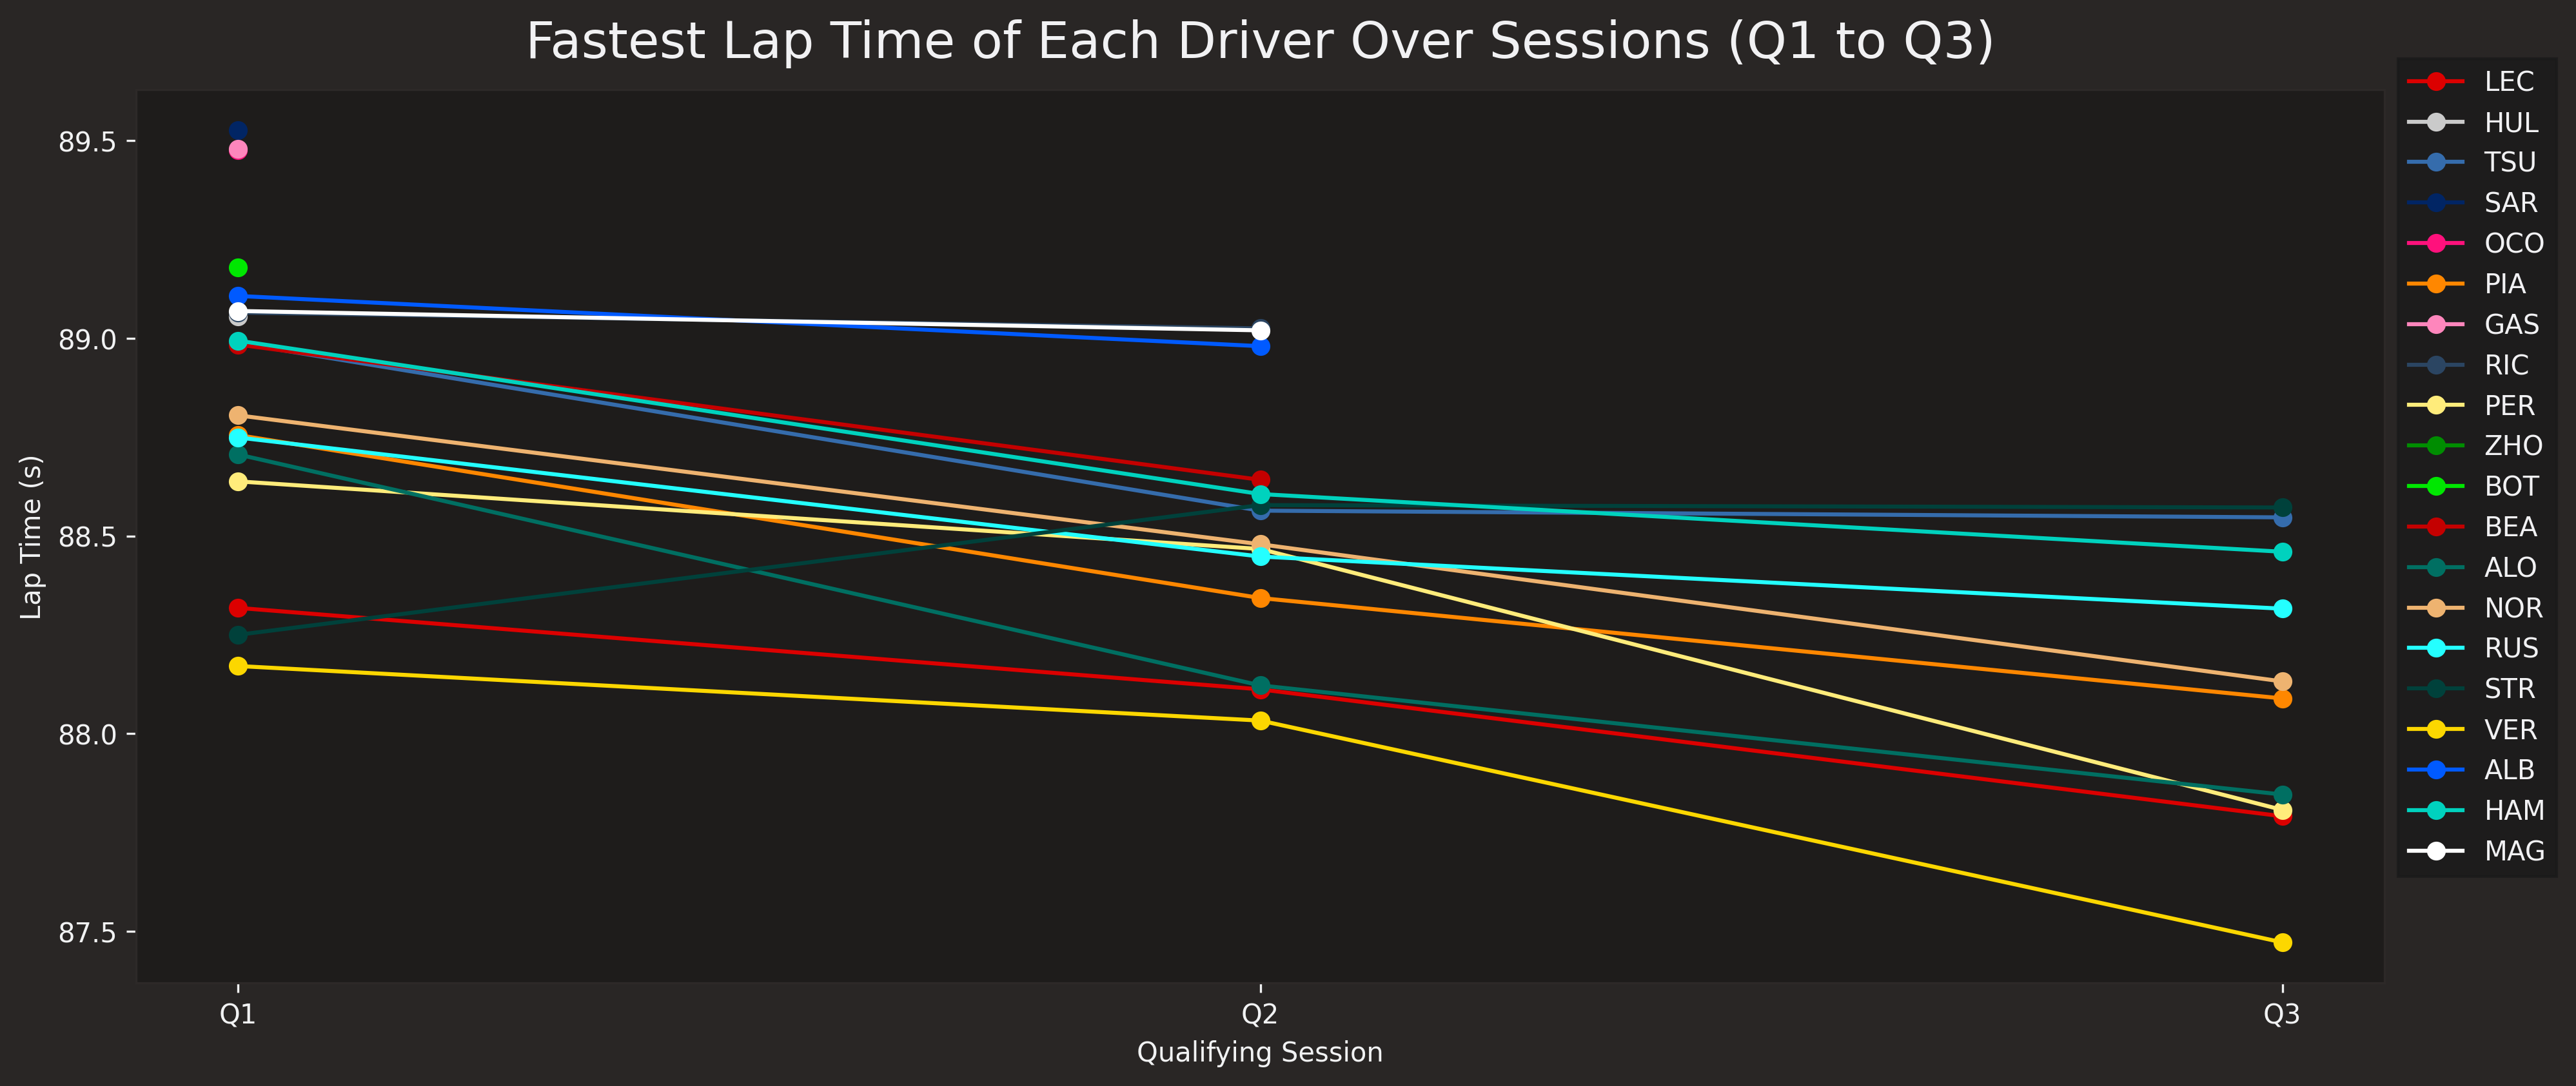

In [9]:
all_drivers = set(q1['Driver']).union(set(q2['Driver']), set(q3['Driver']))

plt.figure(figsize=(15, 6), dpi=300)

for driver in all_drivers:
    driver_lap_times = []
    driver_sessions = []

    for round , q_times in enumerate([q1, q2, q3], start=1):
        fastest_lap_time = q_times[(q_times['Driver'] == driver) & (q_times['LapTime'] <= 100)]['LapTime'].min()
        
        if fastest_lap_time is not None:
            driver_lap_times.append(fastest_lap_time)
            driver_sessions.append(round)

    if driver_lap_times:
        color = fastf1.plotting.driver_color(driver) 

        plt.plot(driver_sessions, driver_lap_times, marker='o', label=driver, color=color)

plt.xlabel('Qualifying Session')
plt.ylabel('Lap Time (s)')
plt.title('Fastest Lap Time of Each Driver Over Sessions (Q1 to Q3)')
plt.xticks([1, 2, 3], ['Q1', 'Q2', 'Q3']) 

plt.legend(loc="upper left", bbox_to_anchor=(1, 1.05))

plt.show()


In [10]:
def get_driver_ranking(session):
    return session.groupby('Driver')['Time'].min().sort_values().index.tolist()

In [11]:
sessions = [q1, q2, q3] 
all_drivers_sorted = []
for sess in sessions:
    session_ranking = get_driver_ranking(sess)
    all_drivers_sorted.extend([drv for drv in session_ranking if drv not in all_drivers_sorted])

In [12]:
driver_positions = {driver: i for i, driver in enumerate(all_drivers_sorted)}
compound_colors = fastf1.plotting.COMPOUND_COLORS

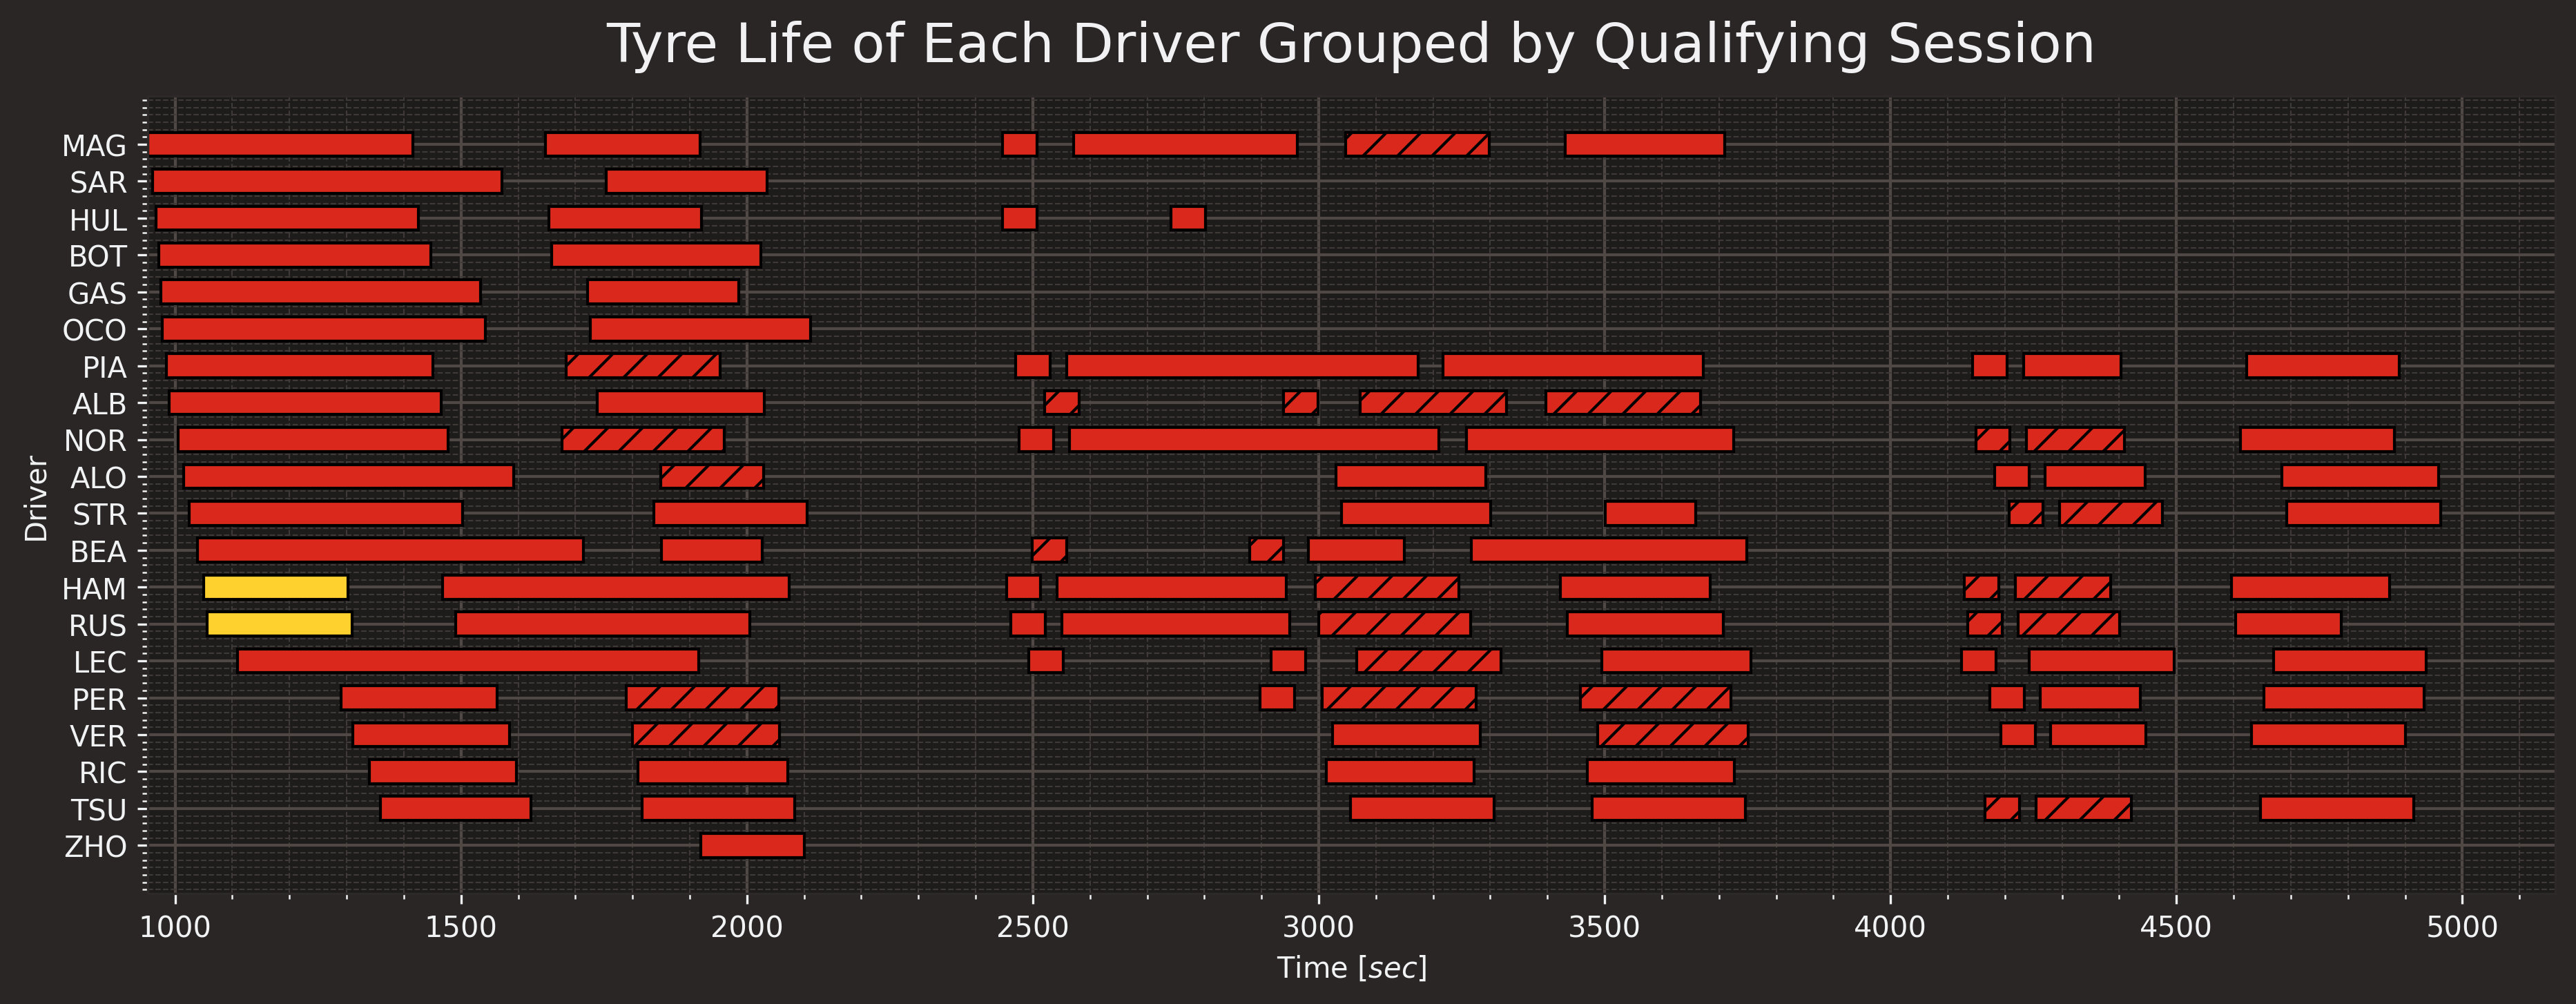

In [13]:
fig, ax = plt.subplots(figsize = (15, 5), dpi = 300 )

for sess in sessions:
    for driver in all_drivers_sorted:
        if driver in sess['Driver'].unique():
            drv_laps = sess[sess['Driver'] == driver].copy()
            drv_laps['TimeInSeconds'] = drv_laps['Time'].dt.total_seconds()
            y_position = driver_positions[driver]

            for (_, compound), group in drv_laps.groupby(['Stint', 'Compound']):
                start_time = group['TimeInSeconds'].min()
                end_time = group['TimeInSeconds'].max() + 60
                color = compound_colors.get(compound.upper(), 'black')
                
                hatch = '//' if not group['FreshTyre'].all() else None
                
                ax.barh(y_position, end_time - start_time, left=start_time, height=0.65, color=color, hatch=hatch, edgecolor='black')

ax.set_yticks(list(driver_positions.values()))
ax.set_yticklabels(all_drivers_sorted)
ax.set_xlabel('Time $[sec]$')
ax.set_ylabel('Driver')
ax.set_title('Tyre Life of Each Driver Grouped by Qualifying Session')
ax.invert_yaxis()

plt.show()


## Team Mate Comparison

In [14]:
def get_drivers_of_teams(team):
    team_laps = session.laps.pick_team(team)

    drivers = team_laps['Driver'].unique()
    
    return drivers

In [15]:
def plot_driver_laptimes(drivers, session):
    fig, axes = plt.subplots(1, len(drivers),  figsize=(12, 4))
    
    for i, driver in enumerate(drivers):
        driver_data = session.laps.pick_driver(driver).pick_quicklaps().reset_index()
        sns.scatterplot(
            data=driver_data,
            x="LapNumber",
            y="LapTime",
            ax=axes[i],
            hue="Compound",
            palette=fastf1.plotting.COMPOUND_COLORS,
            s=80,
            linewidth=0,
            legend="auto",
        )

        axes[i].set_xlabel("Lap Number")
        axes[i].set_ylabel("Lap Time")
        axes[i].invert_yaxis() 
        axes[i].set_title(f"{driver} Laptimes")
        axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
    plt.tight_layout()
    plt.show()


### Ferrari

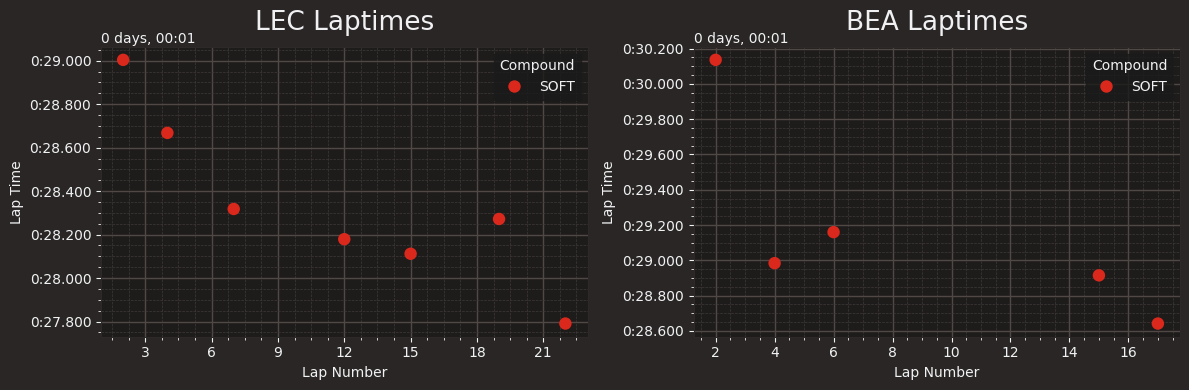

In [16]:
plot_driver_laptimes(get_drivers_of_teams('Ferrari'), session)

In [17]:
fastest_lec = session.laps.pick_drivers('LEC').pick_fastest().get_car_data().add_distance()
fastest_bea = session.laps.pick_drivers('BEA').pick_fastest().get_car_data().add_distance()

In [18]:
plot_data_interactive([fastest_lec, fastest_bea], 'Distance', 'Speed', ['Leclerc', 'Bearman'])

In [19]:
def rotate(xy, angle):
    """Rotate points by a given angle in degrees."""
    angle_rad = np.deg2rad(angle)
    rot_mat = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                        [np.sin(angle_rad), np.cos(angle_rad)]])
    return np.dot(xy, rot_mat.T)

In [57]:
import matplotlib.patches as mpatches

In [72]:

lap_time = fastest_lec.LapTime

# Convert to total seconds
total_seconds = lap_time.total_seconds()

# Convert seconds to minutes
minutes = total_seconds / 60

print(f"{minutes:.4f} minutes")


1.4632 minutes


core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


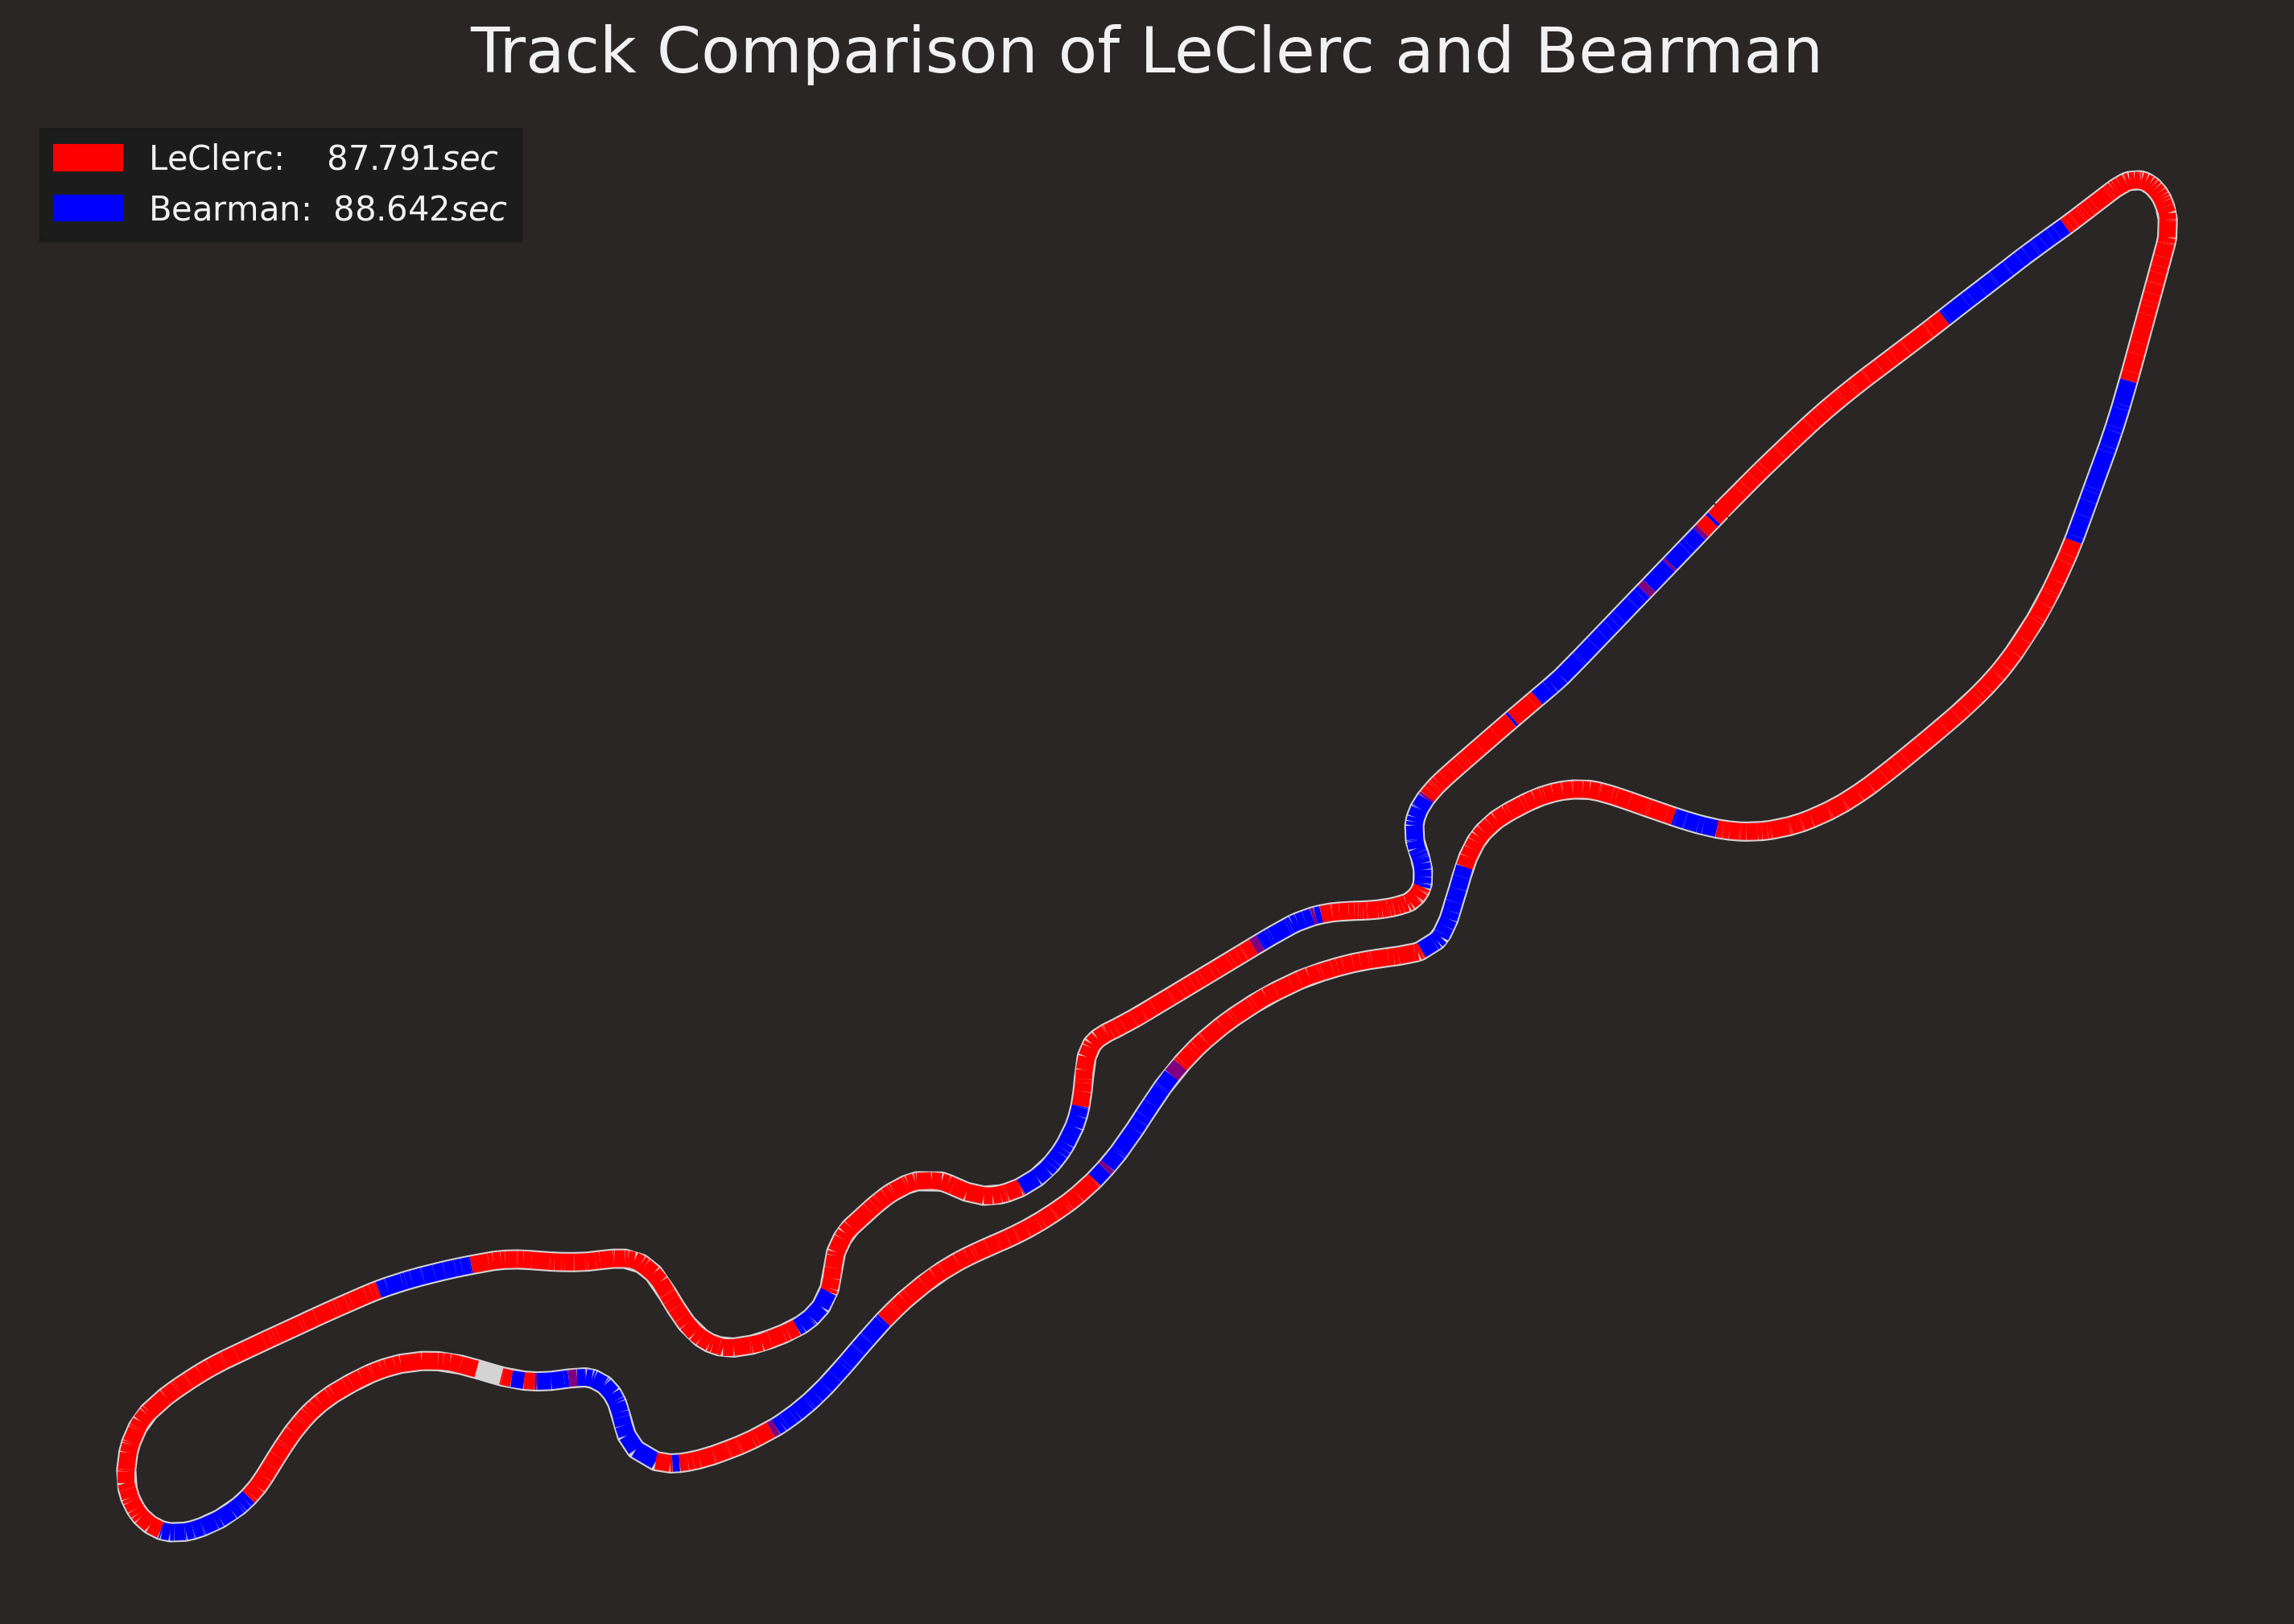

In [81]:
fastest_lec = session.laps.pick_driver('LEC').pick_fastest()
fastest_bea = session.laps.pick_driver('BEA').pick_fastest()
lec_tel = fastest_lec.get_car_data().add_distance()
bea_tel = fastest_bea.get_car_data().add_distance()

speed_diff = lec_tel['Speed'] - bea_tel['Speed']

pos = fastest_lec.get_pos_data()

circuit_info = session.get_circuit_info()
track_angle = circuit_info.rotation
track = pos.loc[:, ('X', 'Y')].to_numpy()

points_lec = rotate(np.array([fastest_lec.telemetry['X'], fastest_lec.telemetry['Y']]).T, angle=track_angle)
points_bea = rotate(np.array([fastest_bea.telemetry['X'], fastest_bea.telemetry['Y']]).T, angle=track_angle)
segments_lec = np.stack([points_lec[:-1], points_lec[1:]], axis=1)
segments_bea = np.stack([points_bea[:-1], points_bea[1:]], axis=1)

rotated_track = rotate(track, angle=track_angle)

plt.figure(figsize=(12, 8), dpi=300)
plt.plot(rotated_track[:, 0], rotated_track[:, 1], color='lightgrey', linewidth=6, zorder=1)

# Create a colormap and norm for line collection
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
colormap = mpl.colors.LinearSegmentedColormap.from_list("", ["blue", "red"]) 
lc_lec = LineCollection(segments_lec, cmap=colormap, norm=norm, linewidth=5)
lc_lec.set_array(speed_diff)

# Add line collection to plot
plt.gca().add_collection(lc_lec)


red_patch = mpatches.Patch(color='red', label=f'LeClerc:    {fastest_lec.LapTime.total_seconds()} $sec$')
blue_patch = mpatches.Patch(color='blue', label=f'Bearman:  {fastest_bea.LapTime.total_seconds()} $sec$')
plt.legend(handles=[red_patch, blue_patch])

plt.title('Track Comparison of LeClerc and Bearman')
plt.axis('off')
plt.show()

### Red Bull

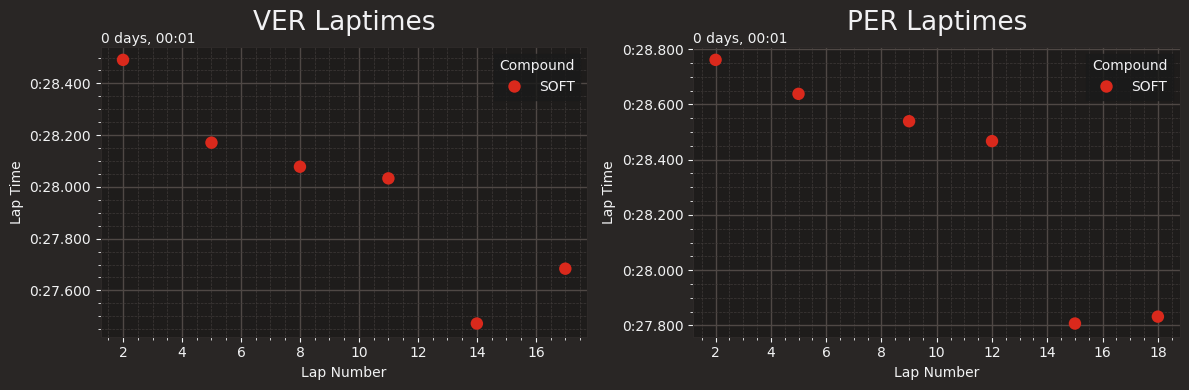

In [21]:
plot_driver_laptimes(get_drivers_of_teams('Red Bull Racing'), session)

### Mercedes 

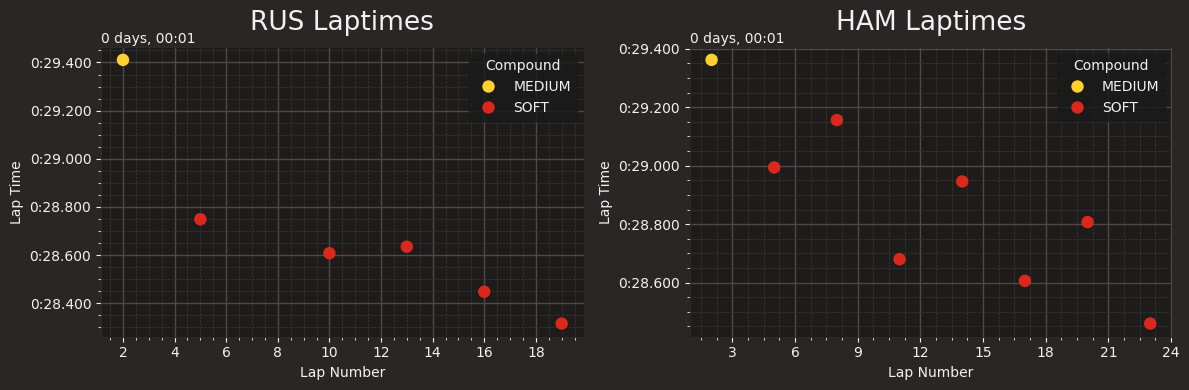

In [22]:
plot_driver_laptimes(get_drivers_of_teams('Mercedes'), session)

### McLaren

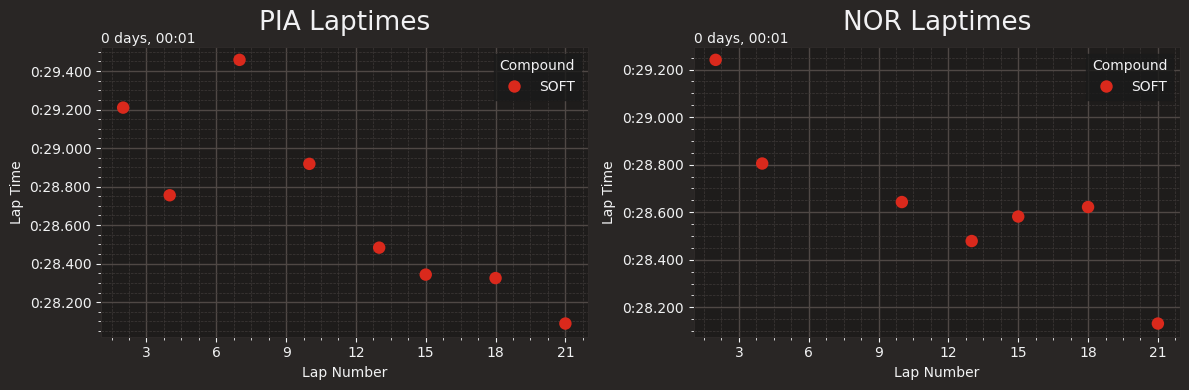

In [23]:
plot_driver_laptimes(get_drivers_of_teams('McLaren'), session)

### Alpine

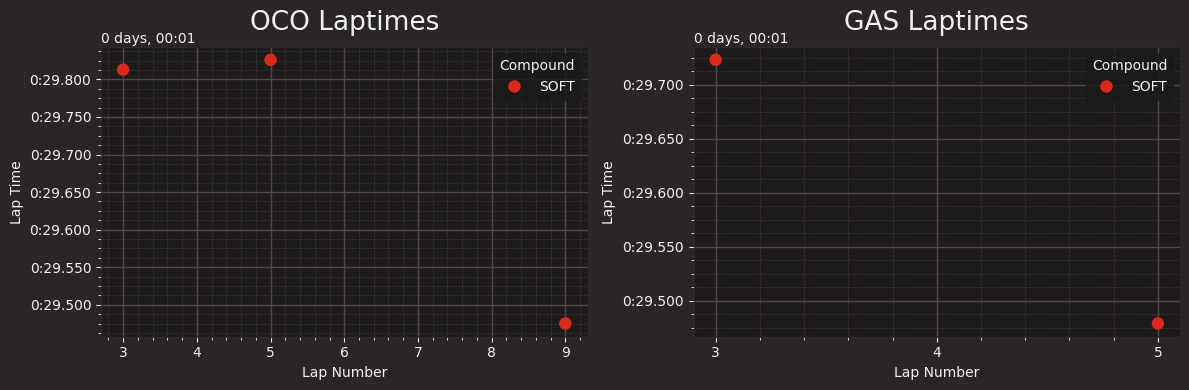

In [24]:
plot_driver_laptimes(get_drivers_of_teams('Alpine'), session)

### Sauber

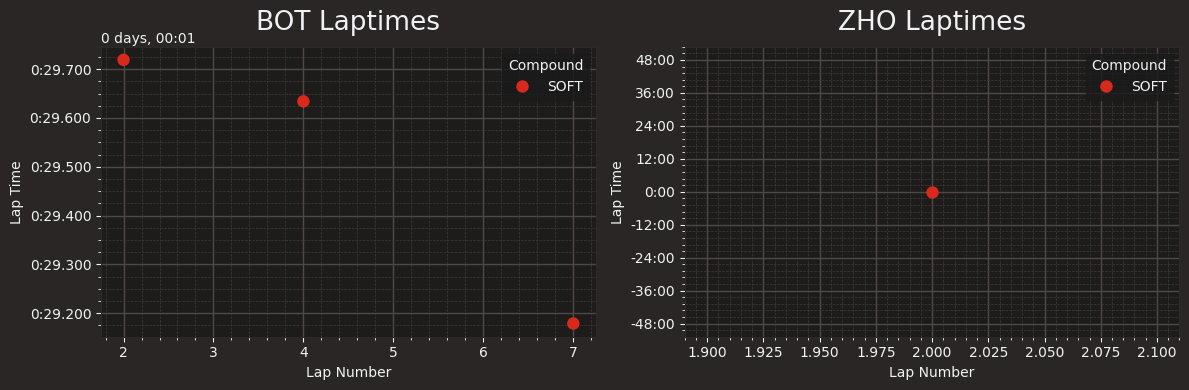

In [25]:
plot_driver_laptimes(get_drivers_of_teams('Kick Sauber'), session)